# Spatial Coincidental Match Probability Exploration

In [1]:
user = 23 # user under consideration 
k = 1 # compute distance to this nearest neighbor of each point

# Interesting users:
#     23: events all over oc, but very consistent (long time to compute)
#     518: very consistent
#     1587: sparse, not consistent, (relatively) large CMP
#     1725: all locations at disneyland
#     4748: bimodal, low score

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from scipy.ndimage import gaussian_filter
from scipy.spatial import KDTree

sys.setrecursionlimit(10000)
%matplotlib inline
init_notebook_mode(connected=True)

pd.options.mode.chained_assignment = None # turn off SettingWithCopyWarning

## Load the parcel assignment data

In [3]:
names = ["event_id", "user_id", "location_id", "lon", "lat", "epoch_time", "day_id", "seconds_since_monday"]
directory = os.path.join("..", "data", "parcel_ass", "oc")

# non-filtered version
data = pd.read_csv(
    os.path.join(directory, "ass_events_no_filter.csv"), 
    header = None, 
    names = names
)
data.drop(['epoch_time', 'seconds_since_monday'], axis=1, inplace=True)
print(data.shape)
data.head()

(655917, 6)


,event_id,user_id,location_id,lon,lat,day_id
0,80.0,3.271973e+09,580595.0,-117.83114,33.71747,107.0
1,83.0,8.705607e+08,364638.0,-117.68922,33.64697,107.0
2,94.0,2.889665e+08,73888.0,-117.87736,33.92656,107.0
3,168.0,1.368289e+09,305182.0,-117.96656,33.93684,107.0
4,236.0,1.932591e+07,338684.0,-117.67928,33.59520,107.0


### Filter & relabel ids

In [4]:
# remap user id for easier handling
user_dict = {}
index = 0
for ident in data.user_id.unique():
    if ident not in user_dict:
        user_dict[ident] = index
        index += 1

data["new_user_id"] = data.user_id.apply(lambda x: user_dict[x])

# reset day id to start at 0
data["day_id"] = data["day_id"] - data['day_id'].min()

# calculate week and month ids
data["week"] = data.day_id // 7
data['month'] = data.day_id // 30

# determine if you want to plot based on weeks or months
time_used = "month"  # "week" 

# calculate the number of events within each time period per user
counts = data.groupby(["new_user_id", time_used]).count()["event_id"]

# filter based on minimum amount of events per time period (n_k)
n_k = 50 # 35
view = counts[counts > n_k].reset_index()
view = view.rename(index=str, columns={'event_id': 'n'})

In [5]:
# join together to have a row for each user for a single month joined with the prior and next month
lagged_view = pd.concat([view, view.shift(1), view.shift(2)], axis = 1)
lagged_view.columns = list("next_" + view.columns) + list(view.columns) + list("last_" + view.columns)

# filter rows so that they only contain pairs where there is a sequential month present
right_users = (lagged_view["new_user_id"] == lagged_view["next_new_user_id"]) | (lagged_view["new_user_id"] == lagged_view["last_new_user_id"])
sequential = ((lagged_view["next_"+time_used] - lagged_view[time_used]) == 1) | ((lagged_view[time_used] - lagged_view["last_"+time_used]) == 1)
filtered = lagged_view[right_users & sequential][["new_user_id", time_used, "n"]].reset_index(drop=True)
filtered.head()

,new_user_id,month,n
0,1.0,0.0,918.0
1,1.0,1.0,1044.0
2,1.0,2.0,1450.0
3,1.0,3.0,1586.0
4,1.0,4.0,1075.0


In [6]:
# gather ids and valid weeks for the users that have survived the filtering
user_time_dict = {-1 : []}
for i, x in filtered.iterrows():
    user_id = x["new_user_id"]
    time = x[time_used]
    if user_id not in user_time_dict:
        user_time_dict[user_id] = []
    user_time_dict[user_id].append(time)

# reduce the original data to be only valid events
reduced_view = pd.merge(left=filtered, right=data, on=["new_user_id", time_used], how="left")


In [7]:
print("ORIGINAL DATA")
print("Users: ", data['user_id'].nunique())
print("Events:", len(data))

ORIGINAL DATA
Users:  103271
Events: 655917


In [8]:
print("FILTERED DATA")
print("Users: ", reduced_view['user_id'].nunique())
print("Events:", len(reduced_view))

FILTERED DATA
Users:  191
Events: 122444


### Format for CMP

In [9]:
keep = []
for uid, months in user_time_dict.items():
    if all(x in months for x in [0., 1.]):
        keep.append(uid)
keep = keep[1:]  # uid 1 has ~2k events in only 2 locations
print("{} users have at least {} events in each of the first two months (month 0 and 1).".format(len(keep), n_k))

75 users have at least 50 events in each of the first two months (month 0 and 1).


In [10]:
# create a dataframe contianing the data to be analyzed
mpp = reduced_view.loc[(reduced_view['new_user_id'].isin(keep)) & (reduced_view['month'].isin({0., 1.})),].reset_index()
mpp['m'] = np.where(mpp['month'] == 0., 'a', 'b')
mpp = mpp[['new_user_id', 'm', 'lon', 'lat', 'location_id']].rename(index=str, columns={"new_user_id": "uid"})
# filepath = os.path.join("..", "data", "mpp_month0a_month1b_n50.csv")
# mpp.to_csv(filepath, index=False)

In [11]:
n_users = mpp['uid'].nunique()
print("MPP DATA")
print("Users: ", n_users)
print("Events:", len(mpp))
mpp.head()

MPP DATA
Users:  75
Events: 26294


,uid,m,lon,lat,location_id
0,11.0,a,-117.92895,33.61891,409421.0
1,11.0,a,-117.67199,33.60002,382994.0
2,11.0,a,-117.92895,33.61891,409421.0
3,11.0,a,-117.67199,33.60002,382994.0
4,11.0,a,-117.67199,33.60002,382994.0


In [12]:
print("Number of events")
print("----------------")
print("Month 1: ", sum(mpp.m == 'a'), "({} per user)".format(round(sum(mpp.m == 'a')/n_users, 1)))
print("Month 2: ", sum(mpp.m == 'b'), "({} per user)".format(round(sum(mpp.m == 'b')/n_users, 1)))


Number of events
----------------
Month 1:  13695 (182.6 per user)
Month 2:  12599 (168.0 per user)


## Heatmap User vs Parcel

In [13]:
grouped = mpp.groupby(['uid', 'location_id']).count()['lat'].reset_index([0,1])
grouped = grouped.pivot(index='location_id', columns='uid', values='lat')

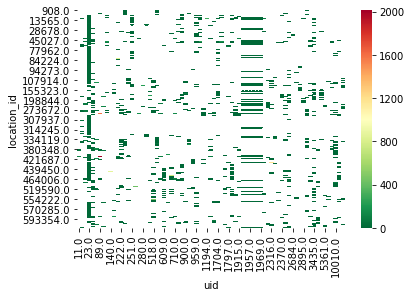

In [14]:
import seaborn as sns
sns.heatmap(grouped, cmap='RdYlGn_r')

## Experiment for one user

In [15]:
mpp_star = mpp.loc[mpp['uid'] == user]
print("User", user)
print("--------------------")
print("Month 1:")
print("  Events:", sum(mpp_star.m == 'a'))
print("  Locations:", mpp_star.loc[mpp_star.m == 'a', 'location_id'].nunique())
print("Month 2:")
print("  Events:", sum(mpp_star.m == 'b'))
print("  Locations:", mpp_star.loc[mpp_star.m == 'b', 'location_id'].nunique())
print("Common Locations:", 
      len(
          np.intersect1d(
              mpp_star.loc[mpp_star.m == 'a', 'location_id'].unique(),
              mpp_star.loc[mpp_star.m == 'b', 'location_id'].unique()
          )
      )
)

User 23
--------------------
Month 1:
  Events: 791
  Locations: 516
Month 2:
  Events: 705
  Locations: 489
Common Locations: 108


### Set up sample space

In [16]:
# user's location set is all unique parcels visited regardless of month
loc_set = mpp_star['location_id'].unique()
len(loc_set)

897

In [17]:
# sample space is any other users' data in either month
samp_sp = mpp.loc[(mpp.uid != user)]

# loop over users in sample space counting number of overlapped parcels
matches = []
for u in samp_sp.uid.unique():
    tmp = samp_sp.loc[samp_sp.uid == u]
    shared_locs = np.intersect1d(
        loc_set,
        tmp['location_id'].unique()
    )
    if len(shared_locs) > 0:
        matches.append(
            {
                'uid': u,
                'n_matches': len(shared_locs),
                'n_events': len(tmp)
            }
        )
matches = pd.DataFrame(matches)

# compute the weight for each matching user's points
tot_matches = sum(matches['n_matches'])
matches['w'] = matches['n_matches'] / (tot_matches  * matches['n_events'])
matches.drop(['n_events', 'n_matches'], axis=1, inplace=True)

# limit the sample space
samp_sp = pd.merge(samp_sp, matches, on='uid')
print('Number of sample points:', len(samp_sp))
print('Sum of weights:', round(sum(samp_sp.w), 2))
samp_sp.head()

Number of sample points: 9539
Sum of weights: 1.0


,uid,m,lon,lat,location_id,w
0,13.0,a,-117.89396,33.91533,73523.0,0.000151
1,13.0,a,-117.89399,33.91534,73523.0,0.000151
2,13.0,a,-117.95623,33.93680,308826.0,0.000151
3,13.0,a,-117.95613,33.93670,308826.0,0.000151
4,13.0,a,-117.89409,33.91531,73523.0,0.000151


### Learn bw for the sample points

In [18]:
from scipy.special import logsumexp
from scipy.spatial import KDTree
from scipy.stats import norm

KM_TO_LON = 0.010615
KM_TO_LAT = 0.008989

def learn_nearest_neighbors_bandwidth(
        sample_points, k=5, lon_to_km=KM_TO_LON, lat_to_km=KM_TO_LAT, min_bw=0.01
    ):
    """
    Learning the bandwidth
    :param data:
    :param k:
    :return:
    """
    k = np.min([k, sample_points.shape[0] - 1])

    bandwidths = []

    anchor_point = np.amin(sample_points, 0)
    dists = sample_points - anchor_point
    
    dists[:, 0] /= lon_to_km
    dists[:, 1] /= lat_to_km

    dists +=  np.random.random(dists.shape) * 0.0000001
    
    # Building the k-d tree
    tree = KDTree(dists, leafsize=500)

    for i in range(dists.shape[0]):
        (neighbors_dists, neighbors_indexes) = tree.query(dists[i, :], k + 1)

        if neighbors_dists[-1] <= min_bw:
            bandwidths.append(min_bw)  # bandwidth can't be less than 1 meter
        else:
            bandwidths.append(neighbors_dists[-1])

    print('Done training bandwidths')
    return np.array(bandwidths)


def log_pdf(query_point, kde_data):
    """
     INPUT:
    -------
        :param query_point:
        :param kde_data:

     OUTPUT:
    --------
        1. log_pdf: <float> The log pdf value
    """

    x_dist = query_point[0] - kde_data[:, 0]
    y_dist = query_point[1] - kde_data[:, 1]
    log_pdf_x = norm.logpdf(x_dist, loc=0, scale=kde_data[:, 2]*KM_TO_LON)
    log_pdf_y = norm.logpdf(y_dist, loc=0, scale=kde_data[:, 2]*KM_TO_LAT)
    
    return logsumexp(log_pdf_x + log_pdf_y) #- np.log( kde_data.shape[0] )


def make_user_scatter_plot(user_data, mark):
    dat = user_data.loc[user_data.m == mark]
    name = "m={}, n={}".format(mark, len(dat))
    return go.Scatter(
        x = dat.lon,
        y = dat.lat,
        mode = 'markers',
        marker = dict(
            color = 'rgb(0, 0, 0)' if mark == 'a' else 'rgb(0,128,0)'
        ),
        name = name,
        visible = "legendonly"
    )

def plot_kde(data, user_data=None, uid=None):
    """
    Compute log pdf values over grid
    
    data: np.array([[lon, lat, bw], ...])
    """
    # evaluate density over OC
    delta = 0.01
    x = np.arange(-118.2, -117.5, delta)  # longitude
    y = np.arange(33.4, 34, delta)  # latitude
    X, Y = np.meshgrid(x, y)
    pts = np.vstack([X.ravel(), Y.ravel()]).T
    z = np.apply_along_axis(log_pdf, 1, pts, kde_data=data)
    out = pd.DataFrame({'lon': pts[:,0], 'lat': pts[:,1], 'lpdf': z})

    # plot the heatmap
    heat = go.Heatmap(
            z = out.lpdf,
            x = out.lon,
            y = out.lat,
            colorscale=[
                [1.0, 'rgb(165,0,38)'], 
                [0.8888888888888888, 'rgb(215,48,39)'], 
                [0.7777777777777778, 'rgb(244,109,67)'], 
                [0.6666666666666666, 'rgb(253,174,97)'], 
                [0.5555555555555556, 'rgb(254,224,144)'], 
                [0.4444444444444444, 'rgb(224,243,248)'], 
                [0.3333333333333333, 'rgb(171,217,233)'], 
                [0.2222222222222222, 'rgb(116,173,209)'], 
                [0.1111111111111111, 'rgb(69,117,180)'], 
                [0.0, 'rgb(49,54,149)']
            ]
        )
    
    traces = [heat]
    layout = go.Layout()
    
    if user_data is not None:
        traces += [make_user_scatter_plot(user_data, mark) for mark in ('a', 'b')]
        
        layout = go.Layout(
            title = "User {}".format(uid),
            legend=dict(x=-.35, y=1)
        )

    fig = go.Figure(data=traces, layout=layout)
    iplot(fig, show_link=False)

In [19]:
# learn the bw
pts = samp_sp.loc[:, ['lon', 'lat']].values
bw = learn_nearest_neighbors_bandwidth(pts, k=5, min_bw=0.05)

# set up data for sampling later on
kde_data = np.hstack(
    [
        np.atleast_2d(samp_sp['uid'].values).T,
        pts, 
        np.atleast_2d(bw).T, 
        np.atleast_2d(samp_sp['w'].values).T
    ]
)

Done training bandwidths


In [20]:
# plot_kde(kde_data[:, 1:4])

### Code to sample from the learned density

In [21]:
np.random.seed(1234)

def sample_from_kde(data, n=1):
    """
    Inputs:
        data: np.array([[user_id, lon, lat, bandwidth, weight], ... ])    
        n: number of samples
    Output:
        np.array of sampled points: np.array([[lon, lat], ...])
    """
    sampled_point_index = np.random.choice(data.shape[0], size=n, p=data[:, -1])
    sampled_points = data[sampled_point_index, :]

    sample_lon = np.random.normal(sampled_points[:, 1], sampled_points[:, 3] * KM_TO_LON)
    sample_lat = np.random.normal(sampled_points[:, 2], sampled_points[:, 3] * KM_TO_LAT)

    return np.vstack([sample_lon, sample_lat]).T

### Distance Function

In [22]:
def kdnearest(a, b, leafsize=10, k=1):
    """
    Measure the Haversine distance from each point in A 
    to its nearest neighbor in B using a KDTree data struct
    built from the locations in B.
    
    Params:
        a: pandas.DataFrame containing <'lat', 'lon'>
        b: pandas.DataFrame containing <'lat', 'lon'>
        leafsize: int specifing the number of data points to 
            place in each leaf node of the KDTree
        k: int number of nearest nei
    Returns:
        pandas.DataFrame of distances in km
    """
    a_copy = a.copy()
    b_copy = b.copy()
    R = 6371  # radius of earth in km
    
    def dist_to_arclength(chord_length):
        """
        https://en.wikipedia.org/wiki/Great-circle_distance
        Convert Euclidean chord length to great circle arc length
        """
        central_angle = 2*np.arcsin(chord_length/(2.0*R)) 
        arclength = R*central_angle
        return arclength

    def to_cartesian(data):
        """convert to Cartesian coordinates"""
        phi = np.deg2rad(data['lat'])
        theta = np.deg2rad(data['lon'])
        data['x'] = R * np.cos(phi) * np.cos(theta)
        data['y'] = R * np.cos(phi) * np.sin(theta)
        data['z'] = R * np.sin(phi)
        return data[['x', 'y','z']]
    
    # build the tree and query it  
    btree = KDTree(to_cartesian(b_copy), leafsize=leafsize)
    dist, idx = btree.query(to_cartesian(a_copy), k=k)
    if k > 1:
        return dist_to_arclength(dist)[:, k-1]
    return dist_to_arclength(dist)

### Perform CMP Calculation

In [23]:
a_star = mpp_star.loc[mpp_star['m'] == 'a']  # fix events in A^*
a_star_unique = a_star.drop_duplicates(subset='location_id')
b_star = mpp_star.loc[mpp_star['m'] == 'b'] 
b_star_unique = b_star.drop_duplicates(subset='location_id')

n_sim = 1000
n_b_star = len(b_star_unique)

sim = {}
scores = {}
for ell in range(n_sim):
    sim[ell] = {}
    sim[ell]['locations'] = sample_from_kde(kde_data, n=n_b_star)
    s = pd.DataFrame(sim[ell]['locations'], columns=['lon', 'lat'])
    sim[ell]['dists'] = kdnearest(a=a_star_unique, b=s, k=k)
    
    scores[ell] = {}
    scores[ell]['mean_dist'] = np.mean(sim[ell]['dists'])
    scores[ell]['med_dist'] = np.median(sim[ell]['dists'])

In [24]:
scores = pd.DataFrame.from_dict(scores, orient='index')
scores.describe()

,mean_dist,med_dist
count,1000.000000,1000.000000
mean,1.099962,1.005038
std,0.057300,0.055977
min,0.949504,0.804567
25%,1.063221,0.969726
50%,1.098876,1.006536
75%,1.137896,1.038846
max,1.295220,1.224796


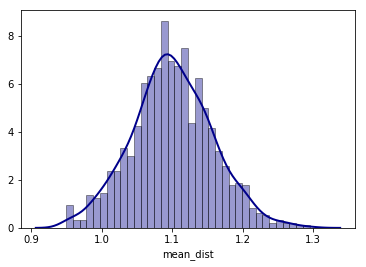

In [25]:
# mean dist to kth nn
sns.distplot(
    scores['mean_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)

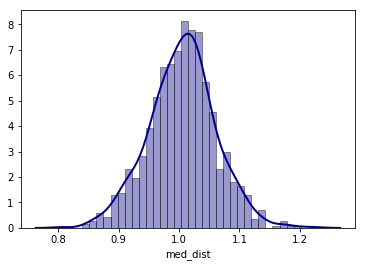

In [26]:
# median dist to kth nn
sns.distplot(
    scores['med_dist'], 
    hist=True, 
    kde=True, 
    bins=int(180/5), 
    color = 'darkblue', 
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 2}
)

In [27]:
obs_dist = kdnearest(a=a_star_unique, b=b_star_unique, k=k)
print(np.mean(obs_dist))
print(np.median(obs_dist))

0.2837397654455525
0.1477936830216794


In [28]:
print("CMPs")
print("--------------")
print("Mean dist:", sum(scores.mean_dist < np.mean(obs_dist)) / n_sim )
print("Median dist:", sum(scores.med_dist < np.median(obs_dist)) / n_sim )

CMPs
--------------
Mean dist: 0.0
Median dist: 0.0


### KDE with user's data overlaid

In [29]:
plot_kde(
    data=kde_data[:, 1:4], 
    user_data=pd.concat([a_star_unique, b_star_unique]),
    uid=user
)